# Light curve plotting

**Note:** This is an older notebook that shows the first version of the light curve preprocessing. In this version, the entire process was based on the Python package **Lightkurve**, allowing the development of a simpler function for plotting any desired object and signal. This contrasts with the newer notebook, where we are constrained by a more limited dataset and therefore we use this notebook to present out light curve plots.


## Datasets

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Example: Kepler dataset
dfK = pd.read_csv("datasets/KEPLER.csv", sep=",", comment="#")

print("Original shape:", dfK.shape)
dfK.head()

Original shape: (9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [3]:
# Example: TESS dataset
dfT = pd.read_csv("datasets/TESS.csv", sep=",", comment="#")

print("Original shape:", dfT.shape)
dfT.head()

Original shape: (7699, 65)


,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


# Preprocessing signals

Preprocessing based on lighkurve following the same method as the analog notebook.

In [4]:
import numpy as np
import pandas as pd
import json as _json
import lightkurve as lk
import sys
import os
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import LSQUnivariateSpline
import json as _json


In [5]:
# General functions

def _med_und_sigma(x):
    x = np.asarray(x, float)
    med = np.nanmedian(x)
    sig = np.nanstd(x)
    return med, sig

def _nan_interpolation(y):
    y = np.asarray(y, float)
    if y.size == 0: return y # if empty, do nothing
    n = y.size; m = np.isfinite(y) # n is the length and m is boolean masko
    if m.all(): return y # if there are no nans just return as it is
    ii = np.arange(n)
    if not m[0]: # if the first element is not finite
        first = np.argmax(m) # we get the index of the first non nan
        y[:first] = y[first] # we fill all the previous nans with that value
        m = np.isfinite(y) # and update the mask
    if not m[-1]: # if the last element is not finite
        last = n-1-np.argmax(m[::-1]) # we get the index of the last non nan (here m[::-1] reverses the mask and with argmax we get the first True in the reversed mask)
        y[last+1:] = y[last] # we fill all the later nans with that value
        m = np.isfinite(y) # and update the mask again
    y[~m] = np.interp(ii[~m], ii[m], y[m]) # ~ bitwise operator, T-> F, F-->T we are filling where false (nans)
    return y

# a pair of functions to resolve IDs and download light curves

def signal_kepler(dfK, kepid_str):
    kid = int(kepid_str) # thwe ID must be a string integer
    signals = dfK[dfK["kepid"].astype(int) == kid].copy()
    if "kepoi_name" in signals.columns:
        signals = signals.sort_values("kepoi_name")
    return kid, signals

def signal_tess(dfT, tid_str):
    tic = int(tid_str)
    signals = dfT[dfT["tid"].astype(int) == tic].copy()
    if "toi" in signals.columns:
        signals = signals.sort_values("toi")
    return tic, signals


def _download(target_id, dataset):
    # we look for the light curve in the specified dataset
    ds = str(dataset).lower().strip()
    if ds == 'kepler':
        tgt = f"KIC {int(target_id)}"; sr = lk.search_lightcurve(tgt, mission='Kepler', author='Kepler')
        if len(sr)==0: sr = lk.search_lightcurve(tgt, mission='Kepler')
    elif ds == 'tess':
        tgt = f"TIC {int(target_id)}"; sr = lk.search_lightcurve(tgt, mission='TESS', author='SPOC')
        if len(sr)==0: sr = lk.search_lightcurve(tgt, mission='TESS')
    else:
        #pass # here we could add more datasets in the future (k2 if i figure out xD))
        print("Unknown dataset")
    lcs = sr.download_all()

    if lcs is None or len(lcs)==0: raise RuntimeError(f'Download failed for {tgt}')

    T, F = [], [] #time and flux arrays
    for lc in lcs:
        try: lc2 = lc.select_flux('pdcsap_flux') # we try to get the PDCSAP flux
        except Exception: lc2 = lc # otherwise we just use the default flux
        lc2 = lc2.remove_nans()
        if len(lc2.flux)==0: continue 
        t = lc2.time.value if hasattr(lc2.time, 'value') else np.asarray(lc2.time, float) # LET IT LIKE OR I GET ERRORS
        f = np.asarray(lc2.flux, float)
        med = np.nanmedian(f)
        if np.isfinite(med) and med!=0: f = f/med # this is the equivalent to flatten
        T.append(t)
        F.append(f)
    if not T: raise RuntimeError(f'No usable light curves for {tgt}')
    t_all = np.concatenate(T); f_all = np.concatenate(F) # form a single array
    s = np.argsort(t_all) # sort by time
    return t_all[s], f_all[s]


In [6]:
# Step 3 & 4: detrending with BIC

# kleine notizen: i skipped the multiple transit cleaning, i dont think its really affects that much

def _fit_spline_with_clipping(t, f, knot_spacing_days, base_use_mask, outlier_sigma=3.0, max_iter=3, spline_degree=3):
    t = np.asarray(t, float); f = np.asarray(f, float)  # make sure both are float numpy arrays

    use_iter = (np.asarray(base_use_mask, bool) & np.isfinite(t) & np.isfinite(f)).copy() # mask of points allowed by base_use_mask and that are finite

    # Initialize trend as a flat line at the median flux
    trend = np.nanmedian(f) * np.ones_like(f)  # init trend = flat line at median (safe default)
    knots = np.array([], float); ok = False    # no knots yet, not ok until we fit something

    # Iterative sigma-clipping loop
    for _ in range(max_iter):
        # Work only on the currently kept points
        tt = t[use_iter]; ff = f[use_iter]
        # If not enough points to fit a spline, break
        if tt.size < 10: break

        # Compute time span and number of spline segments
        tspan = tt.max() - tt.min()            # time span covered by used points
        nseg = max(3, int(tspan / max(knot_spacing_days, 1e-6)))  # number of spline segments (≥3)
        # Compute interior knot positions
        knot_positions = np.linspace(tt.min(), tt.max(), nseg+2)[1:-1]  # interior knots only

        try:
            # Fit a B-spline of given degree to the used points
            spl = LSQUnivariateSpline(tt, ff, knot_positions, k=spline_degree)
            # Evaluate the fitted trend on ALL timestamps
            trend = spl(t)
            # Compute residuals on all points
            res = f - trend
            # Compute robust scatter (median, std) on the used subset
            med, sig = _med_und_sigma(res[use_iter])

            if np.isfinite(sig) and sig>0:
                # Sigma-clip: keep points with |residual| ≤ k·σ
                keep = np.abs(res) <= outlier_sigma*sig
                # Never re-include previously masked points
                new_use = use_iter & keep
                # Check if the mask changed
                changed = not np.array_equal(new_use, use_iter)
                use_iter = new_use; knots = knot_positions; ok = True
                # If mask didn't change, stop iterating
                if not changed: break
            else:
                # If scatter is not finite, accept fit and break
                ok = True; knots = knot_positions; break

        except Exception:
            # If spline fit fails, break and mark as not ok
            ok = False; break

    n = int(np.count_nonzero(use_iter))     # how many points survived the final mask?

    # Compute RSS (residual sum of squares) over the used points
    if n>=2 and np.any(np.isfinite(f[use_iter])) and np.any(np.isfinite(trend[use_iter])):
        rss = float(np.nansum((f[use_iter]-trend[use_iter])**2))
    else:
        rss = np.inf                        # mark as bad fit (used by BIC selection later)

    # Return full trend, mask, knots, fit quality
    return trend, use_iter, np.asarray(knots), rss, n, ok  # full trend, mask, knots, fit quality


def select_knot_spacing_via_bic(t, f, base_use_mask, cand_spacings_days=None, outlier_sigma=3.0, max_iter=3, spline_degree=3):
    # Default grid of candidate knot spacings (log-spaced)
    if cand_spacings_days is None:
        cand_spacings_days = np.geomspace(2.0, 30.0, 12)
    # Initialize best result
    best = dict(bic=np.inf, spacing=np.nan, trend=None, use=None, knots=None, rss=np.inf, n=0)
    # Try each candidate spacing
    for spacing in np.atleast_1d(cand_spacings_days):
        # Fit spline with current spacing
        trend, use, knots, rss, n, ok = _fit_spline_with_clipping(t, f, float(spacing), base_use_mask, outlier_sigma=outlier_sigma, max_iter=max_iter, spline_degree=spline_degree)
        # Skip if fit failed or not enough points
        if not ok or not np.isfinite(rss) or n<=5: continue
        # Number of model parameters (knots + degree + 1)
        k_params = int((len(knots) if knots is not None else 0) + spline_degree + 1)
        k_params = min(k_params, max(1, n-1))
        # Estimate variance
        sigma2 = max(rss/n, 1e-30)
        # Compute BIC
        bic = n*np.log(sigma2) + k_params*np.log(n)
        # Update best if BIC improved
        if bic < best['bic']:
            best.update(dict(bic=float(bic), spacing=float(spacing), trend=trend, use=use,
                             knots=knots, rss=float(rss), n=int(n)))
    # Return best fit info
    return best

def flatten_with_spline(time_arr, flux_arr, P_days, D_hours,
                        bic_grid_days=None,
                        outlier_sigma=3.0, max_iter=3):
    t = np.asarray(time_arr, float); f = np.asarray(flux_arr, float)

    base_use = np.isfinite(t) & np.isfinite(f)  # this is a mask of only finite points
    # select best spline fit via BIC
    best = select_knot_spacing_via_bic(t, f, base_use, cand_spacings_days=bic_grid_days, outlier_sigma=outlier_sigma, max_iter=max_iter, spline_degree=3)
    # if no good fit, fall back to default knot spacing
    if best is None or not np.isfinite(best['bic']):
        Dd = (D_hours if (D_hours and np.isfinite(D_hours)) else 0.0)/24.0
        base = max(5.0*Dd, 0.2*float(P_days)) if np.isfinite(P_days) else 6.0
        knot_spacing_days = float(np.clip(base, 3.0, 20.0))
        trend, use, knots, rss, n, ok = _fit_spline_with_clipping(t, f, knot_spacing_days, base_use,outlier_sigma=outlier_sigma, max_iter=max_iter)
    else:
        trend = best['trend']
    # this is the equivalent to flatten, again
    flat = f/ trend
    med = np.nanmedian(flat)
    if np.isfinite(med) and med!=0: flat = flat/med
    return trend, flat


In [7]:
# Steps 5–7 (fold, bin, normalize)

# equivalent of folding in lightkurve
def _phase_fold(time_arr, flux_arr, P_days, T0_ref, sort=True):
    t = np.asarray(time_arr, float); f = np.asarray(flux_arr, float)
    P = float(P_days); T0 = float(T0_ref)
    phase = ((t - T0 + 0.5*P) % P)/P - 0.5
    if sort:
        s = np.argsort(phase)
        return phase[s], f[s]
    return phase, f

def _median_in_windows(x, y, centers, width):
    x = np.asarray(x, float); y = np.asarray(y, float)
    half = 0.5*float(width)
    out = np.full(centers.shape, np.nan, float)
    for i, c in enumerate(centers):
        m = (x >= c-half) & (x < c+half)
        if np.any(m): out[i] = np.nanmedian(y[m])
    return out

# here we use lambda and delta as in the paper
def _bin_folded(phase, flux, xmin, xmax, n_bins, delta_factor=1.0):
    lam = (xmax - xmin)/int(n_bins)
    centers = xmin + (np.arange(int(n_bins)) + 0.5)*lam
    delta = max(lam*float(delta_factor), 1e-9)
    yb = _median_in_windows(phase, flux, centers, delta)
    yb = _nan_interpolation(yb)
    return centers, yb

# normalizing vectors
def _depth_normalize_vector(y):
    y = np.asarray(y, float)
    if y.size==0 or not np.any(np.isfinite(y)): return np.zeros_like(y)
    med = np.nanmedian(y); y0 = y - med
    mn = np.nanmin(y0)
    if not np.isfinite(mn) or np.isclose(mn, 0.0): return np.zeros_like(y)
    return y0/(-mn)


def build_model_views(prep,
                      n_global=2001, n_local=201, k_durations=4.0,
                      delta_factor_global=1.0, delta_factor_local=1.6):

    # step 5
    if 'phase' not in prep or 'flux_folded' not in prep:
        phase, f_fold = _phase_fold(prep['time_arr'], prep['flux_flat'], prep['period_days'], prep['t0_ref'])
        prep['phase'], prep['flux_folded'] = phase, f_fold

    # step 6
    P = float(prep['period_days'])
    D_days = float(prep['duration_hours']) / 24.0

    g_x, g_y = _bin_folded(prep['phase'], prep['flux_folded'], -0.5, 0.5, n_global, delta_factor_global)

    W = min(0.5, max(1e-5, float(k_durations) * (D_days / max(P, 1e-12))))
    l_x, l_y = _bin_folded(prep['phase'], prep['flux_folded'], -W, +W, n_local, delta_factor_local)

    # step 7
    g_y = _depth_normalize_vector(g_y)
    l_y = _depth_normalize_vector(l_y)

    # storing
    prep['global_view'] = dict(centers=g_x, values=g_y, n_bins=int(n_global))
    prep['local_view']  = dict(centers=l_x, values=l_y, n_bins=int(n_local))
    return prep



In [8]:
def _extract_kepler_ephem(row):
    # Kepler: period [days], epoch [BKJD], duration [hours]
    return float(row['koi_period']), float(row['koi_time0bk']), float(row['koi_duration'])

def _extract_tess_ephem(row):
    # TESS: period [days], epoch [BTJD] from BJD mid-transit, duration [hours]
    return float(row['pl_orbper']), float(row['pl_tranmid']) - 2457000.0, float(row['pl_trandurh'])

def preprocess_signal(row, dataset,
                      outlier_sigma=3.0, max_iter=3,
                      n_global=2001, n_local=201, k_durations=4.0,
                      delta_factor_global=1.0, delta_factor_local=1.6,
                      bic_grid_days=None, verbose=True):
    ds = str(dataset).lower().strip()
    if ds == 'kepler':
        P, T0, D = _extract_kepler_ephem(row); obj_id = int(row['kepid'])
        signal_id = row.get('kepoi_name', None)
    elif ds == 'tess':
        P, T0, D = _extract_tess_ephem(row); obj_id = int(row['tid'])
        signal_id = row.get('toi', None)
    else:
        raise ValueError("dataset must be 'kepler' or 'tess'")

    t_raw, f_raw = _download(obj_id, ds)

    # steps 3–4
    trend, flat = flatten_with_spline(
        t_raw, f_raw, P_days=P, D_hours=D,
        bic_grid_days=bic_grid_days,
        outlier_sigma=outlier_sigma, max_iter=max_iter
    )

    # steps 5–7
    prep = dict(dataset=ds, object_id=obj_id, signal_id=signal_id,
                period_days=P, t0_ref=T0, duration_hours=D,
                time_arr=t_raw, flux_raw=f_raw, trend=trend, flux_flat=flat)

    build_model_views(prep,
                      n_global=n_global, n_local=n_local, k_durations=k_durations,
                      delta_factor_global=delta_factor_global, delta_factor_local=delta_factor_local)

    return prep

In [9]:
def map_kepler_label(row):
    disp = str(row.get('koi_disposition', '')).strip().upper()
    if disp == 'CONFIRMED': return 'planet'
    if disp == 'FALSE POSITIVE': return 'false_positive'
    if disp == 'CANDIDATE': return 'candidate'
    if disp == 'NOT DISPOSITIONED': return 'not_dispositioned'
    return None  # ignore others

def map_tess_label(row):
    disp = str(row.get('tfopwg_disp', '')).strip().upper()
    if disp in {'CP'}: return 'confirmed planet'
    if disp in {'KP'}: return 'known planet'  # Kepler planet in TESS
    if disp in {'FP'}: return 'false_positive' #, 'FA'
    if disp in {'FA'}: return 'false_alarm'
    if disp in {'PC'}: return 'candidate'
    if disp in {'APC'}: return 'ambiguous_planet_candidate'
    
    return None  # ignore others

# this is to turn the bins insto global and local vectors
def _serialize_vec(vec, precision=6):
    arr = np.asarray(vec, float)
    if precision is not None:
        arr = np.round(arr, precision)
    return _json.dumps(arr.tolist(), separators=(',', ':'))

def _append_record_csv(csv_path, rec, header_fields):
    write_header = not os.path.exists(csv_path)
    pd.DataFrame([rec], columns=header_fields).to_csv(csv_path, mode='a', header=write_header, index=False)

def process_and_append_object(obj_str, dataset, df_meta, csv_path,
                              outlier_sigma=3.0, max_iter=3,
                              n_global=2001, n_local=201, k_durations=4.0,
                              delta_factor_global=1.0, delta_factor_local=1.6,
                              bic_grid_days=None, verbose=True):
    ds = dataset.lower().strip()
    header = ["kepid", "kepoi_name", "tid", "toi", "label", "global_vector", "local_vector"]

    if ds == "kepler":
        obj_key, rows = signal_kepler(df_meta, obj_str)
    elif ds == "tess":
        obj_key, rows = signal_tess(df_meta, obj_str)
    else:
        raise ValueError("dataset must be 'kepler' or 'tess'")

    if verbose:
        print(f"[{ds.upper()} {obj_key}] {len(rows)} signals")

    for _, row in rows.iterrows():
        try:
            label = map_kepler_label(row) if ds == "kepler" else map_tess_label(row)
            if label is None:
                if verbose:
                    print("  - Skip unlabeled signal")
                continue

            prep = preprocess_signal(
                row, ds,
                outlier_sigma=outlier_sigma, max_iter=max_iter,
                n_global=n_global, n_local=n_local, k_durations=k_durations,
                delta_factor_global=delta_factor_global, delta_factor_local=delta_factor_local,
                bic_grid_days=bic_grid_days, verbose=verbose
            )

            rec = (dict(
                kepid=int(row["kepid"]), kepoi_name=row.get("kepoi_name", None),
                tid=None, toi=None, label=label,
                global_vector=_serialize_vec(prep["global_view"]["values"]),
                local_vector=_serialize_vec(prep["local_view"]["values"])
            ) if ds == "kepler" else dict(
                kepid=None, kepoi_name=None,
                tid=int(row["tid"]), toi=row.get("toi", None), label=label,
                global_vector=_serialize_vec(prep["global_view"]["values"]),
                local_vector=_serialize_vec(prep["local_view"]["values"])
            ))

            _append_record_csv(csv_path, rec, header_fields=header)
            if verbose:
                print(f"  Appended: {rec.get('kepoi_name') or rec.get('toi')}")

        except Exception as e:
            sig = row.get("kepoi_name", row.get("toi", "unknown"))
            #print(f"  [Warn] Skip signal {sig}: {e}")
            raise RuntimeError(f"Signal {sig} failed: {e}")



## Data extraction

Filters:
- **Kepler**: keep only `koi_disposition ∈ {CONFIRMED, FALSE POSITIVE}`
- **TESS**: keep only `tfopwg_disp ∈ {CP, FP, FA}`

The cell below selects the first **5 unique** IDs from each set and exports a single CSV.

In [10]:
# ----------------- SMALL TEST SAMPLE (append-first design; NO plotting) -----------------

# --- USER: Ensure dfK and dfT are defined before running ---
dfK_filt = dfK[dfK['koi_disposition'].str.upper().isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
dfT_filt = dfT[dfT['tfopwg_disp'].str.upper().isin(['CP', 'FP', 'FA'])].copy()

kic_first5 = list(dict.fromkeys(dfK_filt['kepid'].astype(int).tolist()))[:5]
tic_first5 = list(dict.fromkeys(dfT_filt['tid'].astype(int).tolist()))[:5]
print('Test KICs:', kic_first5)
print('Test TICs:', tic_first5)

# Prepare output CSV paths; start clean for this test
os.makedirs('data', exist_ok=True)
kepler_csv = 'data/kepler_preprocessed.csv'
tess_csv   = 'data/tess_preprocessed.csv'
if os.path.exists(kepler_csv): os.remove(kepler_csv)
if os.path.exists(tess_csv):   os.remove(tess_csv)

# Process Kepler one object at a time, appending each signal row
for obj in kic_first5:
    process_and_append_object(
        obj, 'kepler', dfK_filt, kepler_csv,
        outlier_sigma=3.0, max_iter=3,
        n_global=2001, n_local=201, k_durations=4.0,
        delta_factor_global=1.0, delta_factor_local=1.6,
        verbose=True
    )

# Process TESS one object at a time, appending each signal row
for obj in tic_first5:
    process_and_append_object(
        obj, 'tess', dfT_filt, tess_csv,
        outlier_sigma=3.0, max_iter=3,
        n_global=2001, n_local=201, k_durations=4.0,
        delta_factor_global=1.0, delta_factor_local=1.6,
        verbose=True
    )

print("Kepler CSV:", kepler_csv, "| exists:", os.path.exists(kepler_csv))
print("TESS   CSV:", tess_csv,   "| exists:", os.path.exists(tess_csv))


Test KICs: [10797460, 10848459, 10854555, 10872983, 6721123]
Test TICs: [50365310, 124709665, 106997505, 238597883, 169904935]
[KEPLER 10797460] 2 signals
  Appended: K00752.01
  Appended: K00752.02
[KEPLER 10848459] 1 signals
  Appended: K00754.01
[KEPLER 10854555] 1 signals
  Appended: K00755.01
[KEPLER 10872983] 3 signals
  Appended: K00756.01
  Appended: K00756.02
  Appended: K00756.03
[KEPLER 6721123] 1 signals
  Appended: K00114.01
[TESS 50365310] 1 signals
  Appended: 1000.01
[TESS 124709665] 1 signals
  Appended: 1002.01
[TESS 106997505] 1 signals
  [Warn] Skip signal 1003.01: 502 Server Error: Bad Gateway for url: https://mast.stsci.edu/api/v0/invoke
[TESS 238597883] 1 signals
  Appended: 1004.01
[TESS 169904935] 1 signals
  Appended: 1005.01
Kepler CSV: data/kepler_preprocessed.csv | exists: True
TESS   CSV: data/tess_preprocessed.csv | exists: True


### Plotting

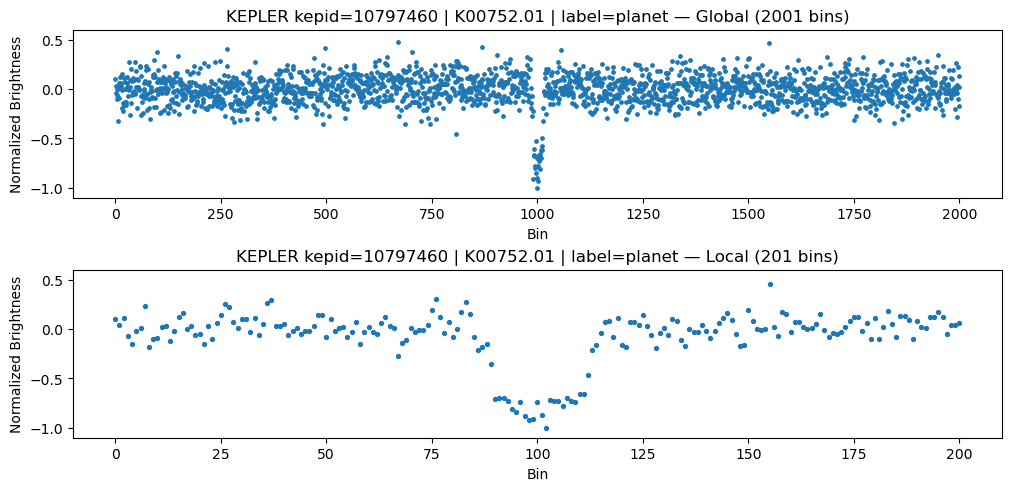

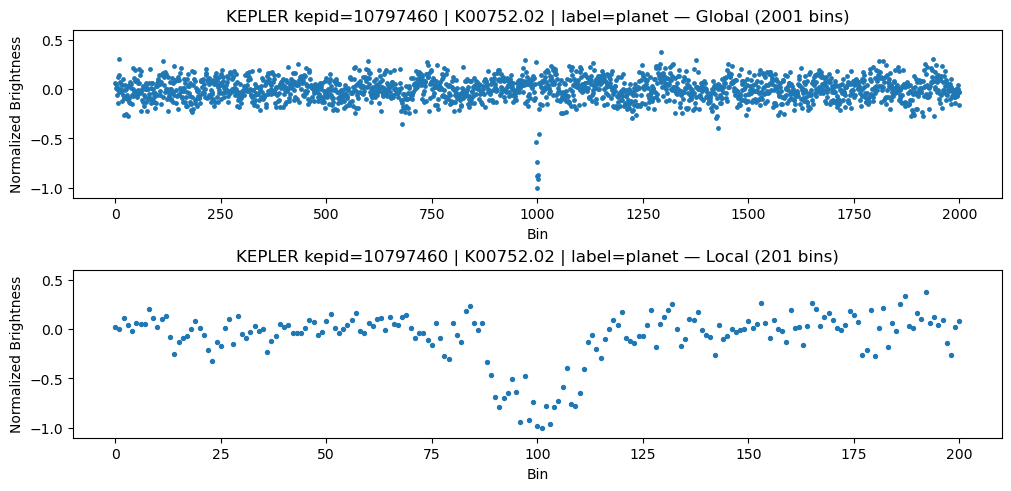

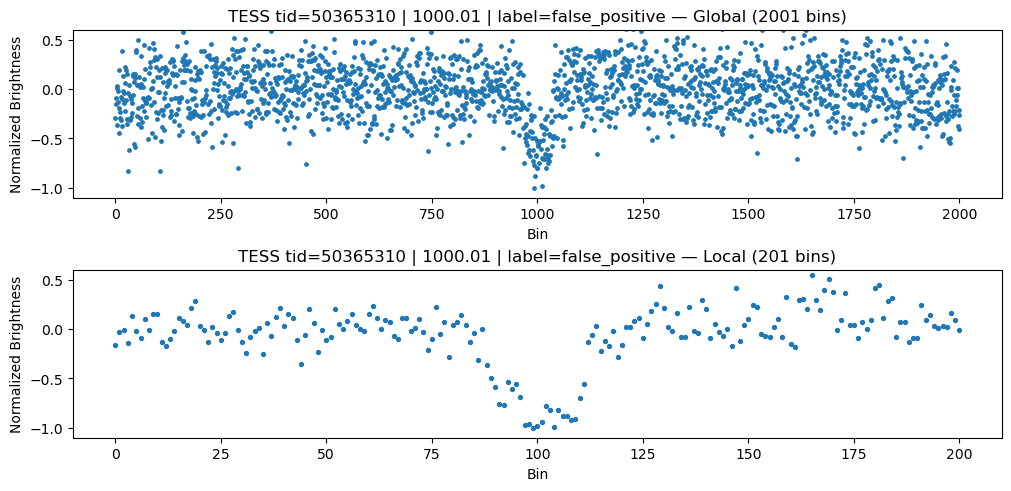

In [12]:
# === Load CSVs ===
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjust paths as needed
KEPLER_CSV = "data/kepler_preprocessed.csv"
TESS_CSV   = "data/tess_preprocessed.csv"

df_kepler = pd.read_csv(KEPLER_CSV)
df_tess   = pd.read_csv(TESS_CSV)

# --- Helpers ---
def _parse_vec(s):
    """Parse a JSON array string -> np.ndarray[float]."""
    if pd.isna(s):
        return np.array([], dtype=float)
    try:
        arr = json.loads(s)
        return np.asarray(arr, dtype=float)
    except Exception:
        # fallback: try comma-separated values
        return np.asarray([float(x) for x in str(s).strip("[]").split(",") if x.strip() != ""], dtype=float)

def _ensure_int(x):
    try:
        return int(str(x).strip())
    except Exception:
        return None

# --- Core plotting function ---
def plot_signal_from_csv(dataset, object_id, df_kepler, df_tess, signal_id=None, max_signals=None):
    """
    Plot the paper-style global & local vectors (Step 7 normalized) for a given object (and optional signal).
    
    Parameters
    ----------
    dataset : {'kepler','tess'}
    object_id : int/str
        Kepler -> kepid ; TESS -> tid
    df_kepler, df_tess : DataFrames
        Loaded CSVs with columns:
        - kepler: kepid, kepoi_name, label, global_vector, local_vector
        - tess:   tid,   toi,         label, global_vector, local_vector
    signal_id : str or None
        'Kxxxxx.yy' for Kepler or TOI string for TESS. If None, plot all signals for that object.
    max_signals : int or None
        Limit the number of signals to plot (useful if an object has many).
    """
    ds = str(dataset).lower().strip()
    obj = _ensure_int(object_id)

    if ds == "kepler":
        if obj is None:
            raise ValueError("For Kepler, object_id must be a valid kepid.")
        df = df_kepler.copy()
        sel = (df["kepid"].astype("Int64") == obj)
        if signal_id is not None:
            sel &= (df["kepoi_name"].astype(str) == str(signal_id))
        view = df.loc[sel]
        id_col, sig_col = "kepid", "kepoi_name"
    elif ds == "tess":
        if obj is None:
            raise ValueError("For TESS, object_id must be a valid tid.")
        df = df_tess.copy()
        sel = (df["tid"].astype("Int64") == obj)
        if signal_id is not None:
            sel &= (df["toi"].astype(str) == str(signal_id))
        view = df.loc[sel]
        id_col, sig_col = "tid", "toi"
    else:
        raise ValueError("dataset must be 'kepler' or 'tess'.")

    if view.empty:
        print(f"[No rows] dataset={dataset}, object_id={object_id}, signal_id={signal_id}")
        return

    if max_signals is not None and len(view) > max_signals:
        view = view.iloc[:max_signals]

    # Plot each matching signal in its own figure (2 stacked axes: Global, Local)
    for _, row in view.iterrows():
        g = _parse_vec(row["global_vector"])
        l = _parse_vec(row["local_vector"])
        sig = row.get(sig_col, None)
        lab = row.get("label", None)

        fig, axes = plt.subplots(2, 1, figsize=(10, 4.8), constrained_layout=True)
        # Global (2001)
        axes[0].scatter(np.arange(g.size), g, s=6)
        axes[0].set_title(f"{dataset.upper()} {id_col}={row.get(id_col)} | {sig} | label={lab} — Global ({g.size} bins)")
        axes[0].set_xlabel("Bin")
        axes[0].set_ylabel("Normalized Brightness")
        axes[0].set_ylim(-1.1, 0.6)

        # Local (201)
        axes[1].scatter(np.arange(l.size), l, s=8)
        axes[1].set_title(f"{dataset.upper()} {id_col}={row.get(id_col)} | {sig} | label={lab} — Local ({l.size} bins)")
        axes[1].set_xlabel("Bin")
        axes[1].set_ylabel("Normalized Brightness")
        axes[1].set_ylim(-1.1, 0.6)

        plt.show()

# --- Examples ---
# Plot ALL signals for a Kepler object:
plot_signal_from_csv('kepler', 10797460, df_kepler, df_tess)

# Plot a specific Kepler signal:
#plot_signal_from_csv('kepler', 10797460, df_kepler, df_tess, signal_id='K00752.01')

# Plot ALL signals for a TESS object:
plot_signal_from_csv('tess', 50365310, df_kepler, df_tess)

# Limit the number of signals shown (if an object has many):
# plot_signal_from_csv('kepler', 7978202, df_kepler, df_tess, max_signals=2)


### Actual download function

In [10]:
# --------- TESS bulk download with simple manual resume ---------
import os

# Unique list of all TICs in the dataframe
tic_list = dfK['kepid'].dropna().astype(int).unique().tolist()
print(f"[Plan] {len(tic_list)} TICs to process")

# Output CSV path (do NOT delete, we append)
os.makedirs('data', exist_ok=True)
kepler_csv = 'data/KEPLER_lk.csv'
print(f"[Out] Appending to: {kepler_csv}")

# --- Manual resume knob ---
# Set CONTINUE_FROM to a TIC number if you want to resume after a crash
# Leave as None to start from the beginning
CONTINUE_FROM = None   # e.g. 106997505

reached = (CONTINUE_FROM is None)

for i, tic in enumerate(tic_list, 1):
    if not reached:
        if tic == int(CONTINUE_FROM):
            reached = True
        else:
            continue

    print(f"\n[{i}/{len(tic_list)}] TIC {tic}")
    sub = dfK[dfK['kepid'].astype(int) == tic]  # rows for this TIC only

    try:
        process_and_append_object(
            str(tic), 'kepler', sub, kepler_csv,
            outlier_sigma=3.0, max_iter=3,
            n_global=2001, n_local=201, k_durations=4.0,
            delta_factor_global=1.0, delta_factor_local=1.6,
            bic_grid_days=None, verbose=True
        )
    except Exception as e:
        print(f"[Error] TIC {tic}: {e}")
        print(f"       Tip: set CONTINUE_FROM = {tic} to restart here.")
        break  # stop so you can fix/retry

print("\n[Done] KEPLER CSV:", kepler_csv, "| exists:", os.path.exists(kepler_csv))


[Plan] 8214 TICs to process
[Out] Appending to: data/KEPLER_lk.csv

[1/8214] TIC 10797460
[KEPLER 10797460] 2 signals
  Appended: K00752.01
  Appended: K00752.02

[2/8214] TIC 10811496
[KEPLER 10811496] 1 signals
  Appended: K00753.01

[3/8214] TIC 10848459
[KEPLER 10848459] 1 signals
  Appended: K00754.01

[4/8214] TIC 10854555
[KEPLER 10854555] 1 signals
  Appended: K00755.01

[5/8214] TIC 10872983
[KEPLER 10872983] 3 signals
  Appended: K00756.01
  Appended: K00756.02
  Appended: K00756.03

[6/8214] TIC 6721123
[KEPLER 6721123] 1 signals
  Appended: K00114.01

[7/8214] TIC 10910878
[KEPLER 10910878] 3 signals
  Appended: K00757.01
  Appended: K00757.02
  Appended: K00757.03

[8/8214] TIC 11446443
[KEPLER 11446443] 1 signals
  Appended: K00001.01

[9/8214] TIC 10666592
[KEPLER 10666592] 1 signals
  Appended: K00002.01

[10/8214] TIC 6922244
[KEPLER 6922244] 1 signals
  Appended: K00010.01

[11/8214] TIC 10984090
[KEPLER 10984090] 2 signals
  Appended: K00112.01
  Appended: K00112.02
